In [144]:





import datetime
import pytz
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta






In [145]:





# 30 min time frame
frameM30 = mt5.TIMEFRAME_M30

#1 min time frame
frameM1 = mt5.TIMEFRAME_M1

# 1 hour time frame
frameH1 = mt5.TIMEFRAME_H1





In [146]:





def getAssetList(assetSet = None):
    assetList = []
    if assetSet == 1:
        assetList = ['EURUSD', 'USDCHF']
    return assetList

        





In [147]:







## Defining the getQuotes method

def getQuotes(mt5TimeFrame, year = 2020, month = 1, day = 1, asset ='EURUSD'):
    
    ## Establishing the connection to MetaTrader 5
    if not mt5.initialize():
        print(f'MT5 initialization failed: Error code = {mt5.last_error}')
        quit()

    # Current time
    currentTime = datetime.datetime.now()

    # Defining the timezone and created utcFrom and utcTo dates
    timeZone = pytz.timezone('Asia/Kolkata')
    utcFrom = datetime.datetime(year, month, day, tzinfo = timeZone)
    utcTo = datetime.datetime(currentTime.year, currentTime.month, currentTime.day, tzinfo = timeZone)
    
    # Retrieving the data and returning it after converting it to pd dataframe
    return pd.DataFrame(mt5.copy_rates_range(asset, mt5TimeFrame, utcFrom, utcTo))







In [148]:



df = getQuotes(frameM30, 2023)
df





,time,open,high,low,close,tick_volume,spread,real_volume
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0
...,...,...,...,...,...,...,...,...
9835,1697232600,1.05078,1.05119,1.05047,1.05107,2348,9,0
9836,1697234400,1.05107,1.05137,1.05089,1.05108,2079,9,0
9837,1697236200,1.05108,1.05154,1.05103,1.05134,1835,9,0
9838,1697238000,1.05134,1.05135,1.05074,1.05081,782,9,0


In [149]:


def slope(df, lookBackPeriod=5):
    df['slope'] = (df['sma'] - df['sma'].shift(lookBackPeriod)) / lookBackPeriod
    return df

def sma(df, lookBackPeriod=20):
    df['sma'] = ta.sma(close=df['close'], length=lookBackPeriod)
    return df




In [150]:

slopelookback=50
smalookback=200

df = sma(df, smalookback)
df = slope(df, slopelookback)

df = df.dropna()

df


,time,open,high,low,close,tick_volume,spread,real_volume,sma,slope
249,1673238600,1.06697,1.06774,1.06689,1.06767,3581,7,0,1.058322,-0.000052
250,1673240400,1.06767,1.06767,1.06667,1.06715,3566,7,0,1.058326,-0.000050
251,1673242200,1.06715,1.06748,1.06658,1.06672,2342,7,0,1.058322,-0.000049
252,1673244000,1.06671,1.06758,1.06664,1.06750,1701,7,0,1.058325,-0.000047
253,1673245800,1.06750,1.06781,1.06738,1.06763,1598,7,0,1.058328,-0.000045
...,...,...,...,...,...,...,...,...,...,...
9835,1697232600,1.05078,1.05119,1.05047,1.05107,2348,9,0,1.057894,-0.000013
9836,1697234400,1.05107,1.05137,1.05089,1.05108,2079,9,0,1.057876,-0.000014
9837,1697236200,1.05108,1.05154,1.05103,1.05134,1835,9,0,1.057863,-0.000014
9838,1697238000,1.05134,1.05135,1.05074,1.05081,782,9,0,1.057848,-0.000013


In [151]:

buyIndices=[]
sellIndices=[]

buys=[]
sells=[]

position = None

sl = 0.5 / 100
tp = 1.5 / 100

slamount = None
tpamount = None


for i in range(len(df)):
    if (i > 0) and (position is None) and (df.iloc[i]['slope'] > 0) and (df.iloc[i - 1]['slope'] < 0):
        buyIndices.append(i)
        buys.append(df.iloc[i]['close'])
        position = 'long'
        slamount = df.iloc[i]['close'] - (sl * df.iloc[i]['close'])
        tpamount = df.iloc[i]['close'] + (tp * df.iloc[i]['close'])
    if (i > 0) and (position == 'long') and (
        (
            (df.iloc[i]['slope'] < 0) and
            (df.iloc[i - 1]['slope'] > 0)
        ) or (
            df.iloc[i]['close'] <= slamount
        ) or (
            df.iloc[i]['close'] >= tpamount
        )
    ):
        sellIndices.append(i)
        sells.append(df.iloc[i]['close'])
        position = None
        slamount = None
        tpamount = None


In [152]:

print(buys)
print(sells)

print(buyIndices)
print(sellIndices)


[1.07279, 1.08434, 1.0891, 1.10119, 1.07537, 1.0667200000000001, 1.06701, 1.07691, 1.09165, 1.09242, 1.09903, 1.10676, 1.07675, 1.06947, 1.07805, 1.09451, 1.09664, 1.1001400000000001, 1.09763, 1.08644, 1.07266, 1.06501, 1.05498]
[1.08246, 1.08681, 1.08462, 1.09445, 1.07118, 1.06137, 1.06003, 1.08547, 1.08571, 1.09438, 1.10078, 1.10088, 1.07131, 1.07001, 1.09423, 1.09523, 1.11313, 1.0941, 1.09643, 1.08079, 1.06675, 1.06637, 1.05535]
[24, 462, 744, 858, 1263, 1805, 2175, 2473, 2808, 3234, 3593, 3978, 4997, 5123, 5232, 5827, 6228, 7226, 7304, 8028, 8459, 8802, 9351]
[398, 709, 759, 886, 1315, 1840, 2275, 2756, 2863, 3471, 3842, 4006, 5021, 5177, 5453, 5868, 6366, 7268, 7415, 8138, 8567, 8819, 9566]


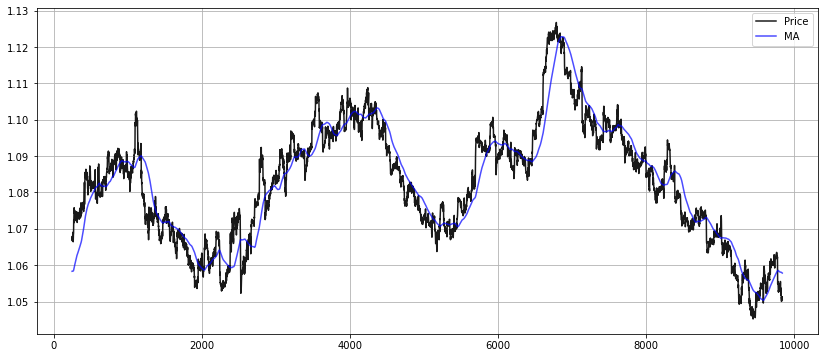

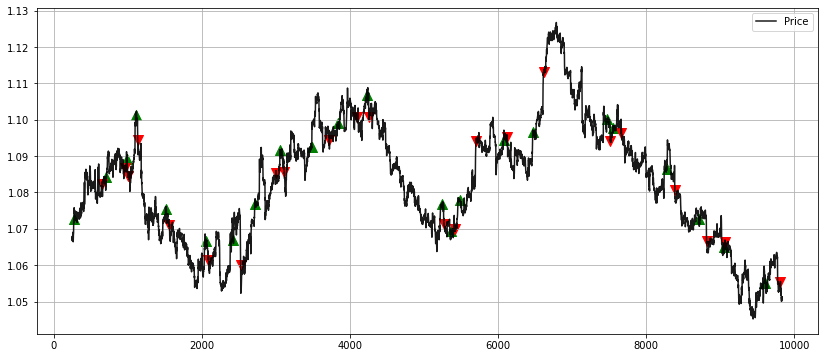

In [153]:


plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Price', color='black', alpha=0.9)
plt.plot(df['sma'], label='MA', color='blue', alpha=0.7)
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Price', color='black', alpha=0.9)
plt.scatter(df.iloc[buyIndices].index, df.iloc[buyIndices]['close'], marker = '^', color = 'g', s = 100)
plt.scatter(df.iloc[sellIndices].index, df.iloc[sellIndices]['close'], marker = 'v', color = 'r', s = 100)
plt.legend()
plt.grid(True)
plt.show()


In [154]:


brokerage = 1 / 100

wins = 0
losses = 0

profit = 0
loss = 0

averageprofit = 0
averageloss = 0

netresult = ''

for i in range(len(sells)):
    maximum = max(sells[i], buys[i])
    brokerageAmount = brokerage * maximum
    diff = sells[i] - buys[i] - brokerageAmount
    if (diff > 0):
        wins += 1
        profit += diff
    if (diff < 0):
        losses += 1
        loss += abs(diff)

if (profit > loss):
    netresult = 'Win'
elif (profit == loss):
    netresult = 'None'
else:
    netresult = 'Loss'

averageprofit = profit / wins
averageloss = loss / losses
hitratio = (wins / (wins + losses)) * 100
profitfactor = (profit / loss)
expectancy = (averageprofit * hitratio) - (averageloss * (1 - hitratio))
riskreward = (averageprofit / averageloss)

print(f'''
    Net result = {netresult}
    Hit ratio = {hitratio} %
    Profit factor = {profitfactor} {{currency}}
    Expectancy = {expectancy} {{currency}}
    Realised risk reward ratio = {riskreward} {{currency}}
''')







    Net result = Loss
    Hit ratio = 8.695652173913043 %
    Profit factor = 0.04012529403656716 {currency}
    Expectancy = 0.14284698881987584 {currency}
    Realised risk reward ratio = 0.4213155873839552 {currency}

